# Image Scaling: Downsampling and Upsampling


In [1]:
# Code from previous section
using Plots
Base.showable(::MIME"image/svg+xml", ::Plots.Plot) = false  # Disable SVG

using FileIO

to3Darray(img) = Float32[ getfield(pxl, fld) for pxl in img, fld in (:r,:g,:b) ]
toRGBarray(img) = RGB.(eachslice(img[:,:,:], dims=3)...)
imread(filename) = to3Darray(load(filename))
imshow(img; args...) = plot(toRGBarray(img); aspect_ratio=:equal, axis=nothing, border=:none, args...)

imshow (generic function with 1 method)

In [2]:
# Read sample image and convert to grayscale
A = imread("sample_photo.png")
B = sum(A, dims=3) / 3;

## Downsampling by Averaging

A common image operation is **scaling**, or changing the number of pixels in the image. Let's first consider *downsampling*, which reduces the image size. 

The simplest method would be to just pick every *other* pixel (e.g., `A[1:2:end, 1:2:end, :]`). However, this "pixel-skipping" approach can lead to jagged edges and weird visual artifacts (known as *aliasing*). 

A better-looking and more common method is to **average** the pixels in small blocks. To downsample by a factor of 2, we can average the pixel values in each 2x2 block. This gives a single new pixel that better represents the original 2x2 area.

Level 1 size: (342, 456, 1)
Level 2 size: (171, 228, 1)
Level 3 size: (85, 114, 1)
Level 4 size: (42, 57, 1)


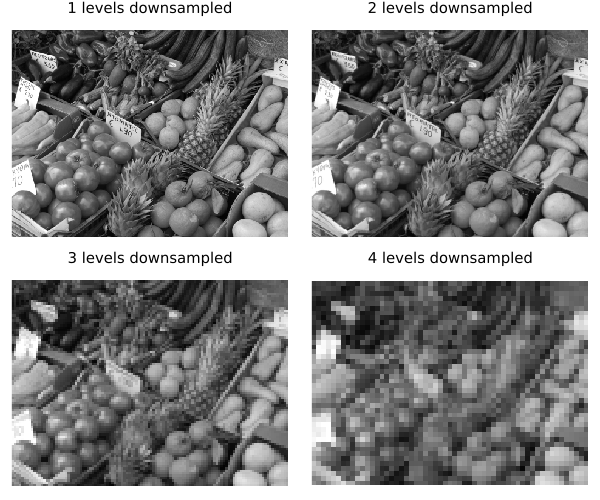

In [3]:
function image_downsample(A)
    # Get the size of the input image
    sz = size(A)
    
    # Calculate the size of the new image (half the size).
    # `÷` is integer division, which handles odd dimensions by flooring.
    sz2 = sz .÷ 2
    
    # We'll create an output array by selecting 2x2 blocks and averaging them.
    # `2sz2[1]` gives the largest even number <= sz[1]. This cleverly 
    # handles odd dimensions by simply ignoring the last row/column.
    
    # Average the four pixels in each 2x2 block:
    B = (A[1:2:2sz2[1], 1:2:2sz2[2], :] .+  # Top-left pixels
         A[2:2:2sz2[1], 1:2:2sz2[2], :] .+  # Bottom-left pixels
         A[1:2:2sz2[1], 2:2:2sz2[2], :] .+  # Top-right pixels
         A[2:2:2sz2[1], 2:2:2sz2[2], :])    # Bottom-right pixels
    
    return B ./ 4  # Divide by 4 to get the average
end

# Let's repeatedly downsample the image 4 times
C = copy(B) # Start with our grayscale image
plts = []
for i = 1:4
    C = image_downsample(C)
    push!(plts, imshow(C, title="$(i) levels downsampled"))
    println("Level $i size: $(size(C))")
end

plot(plts..., layout=(2,2), titlefontsize=10, size=(600,500))

## Upsampling with Bilinear Interpolation

Going the other way, *upscaling*, is more of an art. We have to *invent* new pixel values where none existed before. We can't perfectly recover the lost detail, but we can make a good guess by **interpolating** (or "blending") between the pixel values we *do* have.

A common method is **bilinear interpolation**. For a 2x upscale, the process works like this:

1.  Create a new, larger array (almost 2x the size).
2.  Place the original pixels at every other row and column (the "corners").
3.  Fill the gaps by averaging: 
    * New pixels in the *rows* are the average of the two original pixels above and below them.
    * New pixels in the *columns* are the average of the two original pixels to their left and right.
    * The new pixels in the *center* are the average of the 4 original corner pixels.

Our function `image_upsample` implements this logic efficiently using array slicing.

Level 1 size: (83, 113, 1)
Level 2 size: (165, 225, 1)
Level 3 size: (329, 449, 1)
Level 4 size: (657, 897, 1)


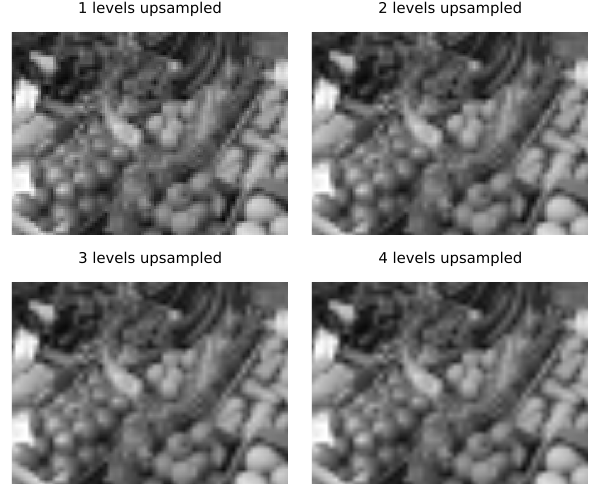

In [4]:
function image_upsample(A)
    sz = size(A)
    # New size is 2N-1. (N pixels have N-1 gaps between them).
    B = zeros(Float32, 2sz[1]-1, 2sz[2]-1, sz[3])
    
    # 1. Place original pixels at `(1,1), (1,3), (3,1)` etc.
    B[1:2:end, 1:2:end, :] .= A
    
    # 2. Interpolate new rows (average pixels above and below)
    B[2:2:end-1, 1:2:end, :] .= (A[1:end-1,:,:] .+ A[2:end,:,:]) ./ 2
    
    # 3. Interpolate new columns (average pixels left and right)
    B[1:2:end, 2:2:end-1, :] .= (A[:,1:end-1,:] .+ A[:,2:end,:]) ./ 2
    
    # 4. Interpolate center points (average of the 4 original corners)
    B[2:2:end-1, 2:2:end-1, :] .= (A[1:end-1,1:end-1,:] .+ A[1:end-1,2:end,:]
                               .+  A[2:end,1:end-1,:] .+ A[2:end,2:end,:]) ./ 4
    return B
end

# Start from our smallest downsampled image 'C'
D = copy(C)
plts = []
for i = 1:4
    D = image_upsample(D)
    push!(plts, imshow(D, title="$(i) levels upsampled"))
    println("Level $i size: $(size(D))")
end
plot(plts..., layout=(2,2), titlefontsize=10, size=(600,500))

## Information Loss

The final upsampled image `D` has *almost* the same dimensions as our original grayscale image `B`. But as you can see, it's much blurrier and less detailed. 

This is expected! When we downsampled, we threw away 75% of the pixels at each step (averaging 4 pixels into 1). The total reduction was by a factor of $2^4 = 16$ in each direction, or $16 \times 16 = 256$ times fewer pixels! The upsampling process can only make a smooth guess at the missing data; it can't magically recover the lost information.

Original size: (684, 912, 1)
Final size:    (657, 897, 1)


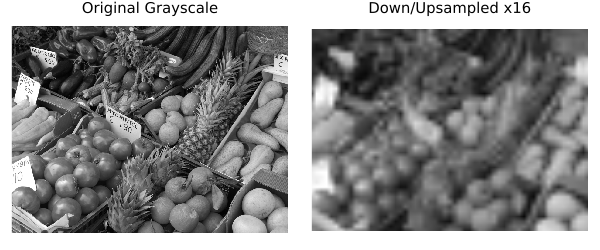

In [5]:
# `D` is the result of 4x downsample + 4x upsample
# `B` is the original grayscale image
println("Original size: $(size(B))")
println("Final size:    $(size(D))")

plts = imshow.((B,D))
plot(plts..., title=["Original Grayscale" "Down/Upsampled x16"],
     layout=(1,2), titlefontsize=10, size=(600,250))

## Scaling by Arbitrary Ratios: Nearest-Neighbor

What if we want to scale by a factor of 1.5, or 0.7? We can't use our 2x2 averaging. We need a more general approach. 

The simplest general method is **Nearest-Neighbor Interpolation**. The algorithm is:

1.  Create a new, blank image `B` with the desired target dimensions (`new_height`, `new_width`).
2.  Calculate the scaling ratios: $r_y = \frac{\text{old\_height}}{\text{new\_height}}$ and $r_x = \frac{\text{old\_width}}{\text{new\_width}}$.
3.  Loop through every single pixel `(y_new, x_new)` in the *new* image `B`.
4.  For each new pixel, find its corresponding coordinate in the *old* image: 
    $y_{old} = y_{new} \times r_y$
    $x_{old} = x_{new} \times r_x$
5.  Since $y_{old}$ and $x_{old}$ will be floating-point numbers, we just `round` them to the *nearest* integer to find the *nearest neighbor* pixel in the old image.
6.  Copy the color from that nearest neighbor: `B[y_new, x_new] = A[round(y_old), round(x_old)]`.

This method is fast, but as you'll see, it can produce a very "blocky" or "pixelated" result when upscaling.

In [6]:
function image_scale_nearest(A, new_size)
    sz_old = (size(A, 1), size(A, 2))
    sz_new = (new_size[1], new_size[2])
    B = zeros(Float32, sz_new[1], sz_new[2])

    # Calculate scaling ratios
    ratio_y = sz_old[1] / sz_new[1]
    ratio_x = sz_old[2] / sz_new[2]

    for y_new in 1:sz_new[1]
        for x_new in 1:sz_new[2]
            # Find corresponding "source" pixel in the old image
            # We map pixel *centers* (e.g., 0.5) instead of edges (e.g., 0.0)
            # This prevents a half-pixel drift in the mapping.
            y_old = (y_new - 0.5) * ratio_y + 0.5
            x_old = (x_new - 0.5) * ratio_x + 0.5

            # Round to nearest integer and `clamp` to valid indices
            # (1 to height) and (1 to width) to avoid `BoundsError`
            y_old_int = clamp(round(Int, y_old), 1, sz_old[1])
            x_old_int = clamp(round(Int, x_old), 1, sz_old[2])

            # Copy the pixel value from the nearest neighbor
            B[y_new, x_new] = A[y_old_int, x_old_int]
        end
    end
    return B
end

image_scale_nearest (generic function with 1 method)

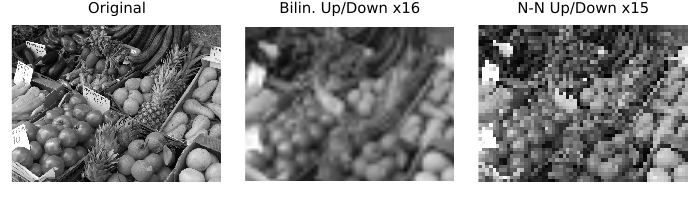

In [7]:
# Let's test it! 
# 1. Downscale the original image 'B' to 1/15 its size
old_size = (size(B,1), size(B,2))
new_size = old_size .÷ 15
B_nearest_down = image_scale_nearest(B, new_size)

# 2. Upscale it back to the original size
B_nearest_up = image_scale_nearest(B_nearest_down, old_size)

# 3. Compare the original, our blurry Bilinear result, and the blocky Nearest-Neighbor result
plot(imshow(B, title="Original"), 
     imshow(D, title="Bilin. Up/Down x16"), 
     imshow(B_nearest_up, title="N-N Up/Down x15"),
     layout=(1,3), titlefontsize=10, size=(700,200))